# $-u''=e^{sin(x)},u(1)=u(0)=0$

In [8]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [9]:
def thomas_tridiag(a, b, c, d):
    """
    Solve Ax=d with tridiagonal A:
      a: lower diag (len N-1), b: main diag (len N), c: upper diag (len N-1)
    Returns x (len N).
    """
    n = len(b)
    cp = np.empty(n-1, dtype=float)
    dp = np.empty(n, dtype=float)
    bp = b.astype(float).copy()

    cp[0] = c[0] / bp[0]
    dp[0] = d[0] / bp[0]
    for i in range(1, n-1):
        denom = bp[i] - a[i-1]*cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2]) / (bp[n-1] - a[n-2]*cp[n-2])

    x = np.empty(n, dtype=float)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - (cp[i-1]*x[i+1] if i>0 else 0.0)
    return x

In [10]:
def fd_solve_dirichlet(N):
    """
    Second-order central difference on N interior nodes.
    Returns (x, u) including boundaries.
    """
    h = 1.0/(N+1)
    x = np.linspace(0.0, 1.0, N+2)
    f = np.exp(np.sin(x[1:-1]))                   # RHS at interior nodes
    main = (2.0/h**2)*np.ones(N)
    off  = (-1.0/h**2)*np.ones(N-1)
    u_in = thomas_tridiag(off, main, off, f)      # Solve tri-diagonal
    u = np.zeros_like(x)
    u[1:-1] = u_in
    return x, u

In [11]:
def grid_refinement(N_list):
    sols = {}
    for N in N_list:
        sols[N] = fd_solve_dirichlet(N)

    rows = []
    for i, N in enumerate(N_list):
        h = 1.0/(N+1)
        E = np.nan
        p = np.nan
        if i >= 1:
            Nc = N_list[i-1]       # coarser
            Nf = N                 # finer
            xc, uc = sols[Nc]
            xf, uf = sols[Nf]
            # interpolate fine solution on coarse grid (includes endpoints)
            uf_on_c = np.interp(xc, xf, uf)
            E = la.norm(uc - uf_on_c, ord=np.inf)

        if i >= 2:
            Eh   = rows[i-1]["E_inf"]   # E_{h}
            Ehh  = rows[i-2]["E_inf"]   # E_{2h}
            if (not np.isnan(Eh)) and (not np.isnan(Ehh)) and Eh>0 and Ehh>0:
                p = np.log2(Ehh / Eh)   # observed order

        rows.append(dict(N=N, h=h, E_inf=E, p_est=p))
    return rows, sols

      N            h          E_inf    p_est
     32   3.0303e-02            nan      nan
     64   1.5385e-02   1.042026e-02      nan
    128   7.7519e-03   5.368914e-03      nan
    256   3.8911e-03   2.719776e-03 0.9566886120380179
    512   1.9493e-03   1.367488e-03 0.9811424165115907
   1024   9.7561e-04   6.853225e-04 0.9919593581383476
   2048   4.8804e-04   3.429739e-04 0.9966736276085714
   4096   2.4408e-04   1.715445e-04 0.9986841362123116

Smallest self-consistency error observed:
N=4096, h=2.441e-04, E_inf=1.715e-04


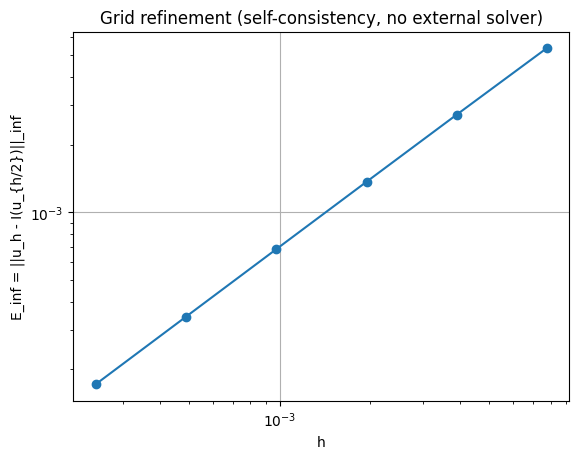

In [12]:
if __name__ == "__main__":
    # Choose a progression; big N is fine thanks to O(N) Thomas solver
    N_list = [32, 64, 128, 256, 512, 1024, 2048, 4096]

    rows, sols = grid_refinement(N_list)

    # Print table
    print(f"{'N':>7} {'h':>12} {'E_inf':>14} {'p_est':>8}")
    for r in rows:
        print(f"{r['N']:7d} {r['h']:12.4e} {r['E_inf']:14.6e} {r['p_est'] if not np.isnan(r['p_est']) else np.nan:8}")

    # Find smallest self-consistency error and where saturation begins
    Es = np.array([r["E_inf"] for r in rows], dtype=float)
    hs = np.array([r["h"] for r in rows], dtype=float)
    finite = np.isfinite(Es)
    if finite.any():
        idx_min = np.nanargmin(Es)
        print("\nSmallest self-consistency error observed:")
        print(f"N={rows[idx_min]['N']}, h={rows[idx_min]['h']:.3e}, E_inf={rows[idx_min]['E_inf']:.3e}")

    # Optional: plot log-log error vs h
    mask = np.isfinite(Es)
    hs_plot = hs[mask][1:]     # drop the first NaN line
    Es_plot = Es[mask][1:]
    import matplotlib.pyplot as plt
    plt.loglog(hs_plot, Es_plot, marker='o')
    plt.xlabel("h")
    plt.ylabel("E_inf = ||u_h - I(u_{h/2})||_inf")
    plt.title("Grid refinement (self-consistency, no external solver)")
    plt.grid(True)
    plt.show()

# $-u''+sin(u)=0,u(1)=u(0)=1$

In [13]:
import numpy as np

In [14]:
def thomas_tridiag(a, b, c, d):
    """
    Solve Ax=d with tridiagonal A:
      a: lower diag (len N-1), b: main diag (len N), c: upper diag (len N-1)
    Returns x (len N).
    """
    n = len(b)
    cp = np.empty(n-1, dtype=float)
    dp = np.empty(n, dtype=float)
    bp = b.astype(float).copy()

    cp[0] = c[0] / bp[0]
    dp[0] = d[0] / bp[0]
    for i in range(1, n-1):
        denom = bp[i] - a[i-1]*cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2]) / (bp[n-1] - a[n-2]*cp[n-2])

    x = np.empty(n, dtype=float)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - (cp[i-1]*x[i+1] if i>0 else 0.0)
    return x


In [15]:
def solve_bvp_nonlinear(N, newton_tol=1e-10, newton_maxit=50, ls_beta=0.5, ls_min=1e-6):
    """
    Second-order FD on N interior nodes with Dirichlet BC u(0)=u(1)=1.
    Newton's method with backtracking line search. Returns x (incl. boundaries) and u.
    """
    h = 1.0/(N+1)
    x = np.linspace(0.0, 1.0, N+2)

    # unknowns are interior values u_1,...,u_N
    u = np.ones(N)  # good initial guess (close to solution)
    # boundary values:
    u0, uN1 = 1.0, 1.0

    def residual(u):
        # F_j = -(u_{j-1}-2u_j+u_{j+1})/h^2 + sin(u_j), with u_0=u0, u_{N+1}=uN1
        F = np.empty_like(u)
        invh2 = 1.0/h**2
        for j in range(N):
            um = u[j-1] if j>0 else u0
            up = u[j+1] if j<N-1 else uN1
            F[j] = -(um - 2.0*u[j] + up)*invh2 + np.sin(u[j])
        return F

    def jacobian_tridiag(u):
        # J = (2/h^2 + cos(u_j)) on diag; -1/h^2 on off-diags
        invh2 = 1.0/h**2
        main = (2.0*invh2 + np.cos(u))
        off  = -invh2 * np.ones(N-1)
        return off, main, off

    # Newton iterations
    F = residual(u)
    for it in range(newton_maxit):
        res_norm = np.linalg.norm(F, ord=np.inf)
        if res_norm < newton_tol:
            break
        a, b, c = jacobian_tridiag(u)
        # Solve J * delta = -F
        delta = thomas_tridiag(a, b, c, -F)
        # backtracking line search to ensure decrease in residual
        t = 1.0
        base = res_norm
        while t >= ls_min:
            u_trial = u + t*delta
            F_trial = residual(u_trial)
            if np.linalg.norm(F_trial, ord=np.inf) < 0.8*base:  # Armijo-like
                u = u_trial
                F = F_trial
                break
            t *= ls_beta
        else:
            # line search failed to reduce -> accept small step to avoid stagnation
            u = u + ls_min*delta
            F = residual(u)

    # Pack full vector including boundaries
    u_full = np.zeros(N+2)
    u_full[0] = u0
    u_full[-1] = uN1
    u_full[1:-1] = u
    return x, u_full, it+1, np.linalg.norm(F, np.inf)

In [16]:
def grid_refinement(N_list):
    sols = {}
    for N in N_list:
        x, u, its, rinf = solve_bvp_nonlinear(N)
        sols[N] = (x, u, its, rinf)

    rows = []
    for i, N in enumerate(N_list):
        h = 1.0/(N+1)
        E = np.nan
        p = np.nan
        its, rinf = sols[N][2], sols[N][3]
        if i >= 1:
            Nc = N_list[i-1]
            (xc, uc, _, _), (xf, uf, _, _) = sols[Nc], sols[N]
            # interpolate fine solution on coarse grid (includes endpoints)
            uf_on_c = np.interp(xc, xf, uf)
            E = np.linalg.norm(uc - uf_on_c, ord=np.inf)
        if i >= 2:
            Eh   = rows[i-1]["E_inf"]   # at h
            E2h  = rows[i-2]["E_inf"]   # at 2h
            if (not np.isnan(Eh)) and (not np.isnan(E2h)) and Eh>0 and E2h>0:
                p = np.log2(E2h / Eh)
        rows.append(dict(N=N, h=h, E_inf=E, p_est=p, newton_its=its, res_inf=rinf))
    return rows, sols

      N            h          E_inf    p_est    its      res_inf
     32   3.0303e-02            nan    nan     50    8.421e-01
     64   1.5385e-02   2.945067e-07    nan     50    8.428e-01
    128   7.7519e-03   1.530282e-07    nan     50    8.441e-01
    256   3.8911e-03   7.779463e-08 0.945     50    8.467e-01
    512   1.9493e-03   3.916821e-08 0.976     50    8.519e-01
   1024   9.7561e-04   1.963857e-08 0.990     50    8.622e-01


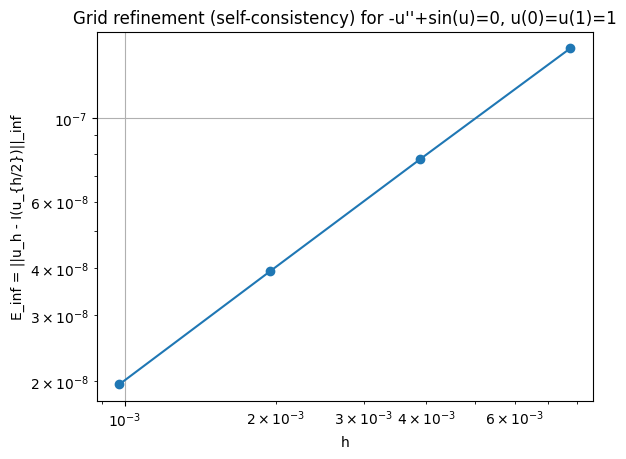

In [17]:
if __name__ == "__main__":
    # Try a geometric sequence of grids
    N_list = [32, 64, 128, 256, 512, 1024]
    rows, sols = grid_refinement(N_list)

    # Print table
    print(f"{'N':>7} {'h':>12} {'E_inf':>14} {'p_est':>8} {'its':>6} {'res_inf':>12}")
    for r in rows:
        print(f"{r['N']:7d} {r['h']:12.4e} {r['E_inf']:14.6e} "
              f"{(f'{r['p_est']:.3f}' if not np.isnan(r['p_est']) else '   nan')} "
              f"{r['newton_its']:6d} {r['res_inf']:12.3e}")

    # Optional: plot convergence (requires matplotlib)
    try:
        import matplotlib.pyplot as plt
        hs = np.array([r["h"] for r in rows], float)
        Es = np.array([r["E_inf"] for r in rows], float)
        mask = np.isfinite(Es)
        hs, Es = hs[mask][1:], Es[mask][1:]  # drop first NaN line
        plt.loglog(hs, Es, marker='o')
        plt.xlabel("h")
        plt.ylabel("E_inf = ||u_h - I(u_{h/2})||_inf")
        plt.title("Grid refinement (self-consistency) for -u''+sin(u)=0, u(0)=u(1)=1")
        plt.grid(True)
        plt.show()
    except Exception as e:
        pass